In [215]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config IPCompleter.greedy=True

In [216]:
mnist = fetch_mldata('MNIST original')

In [217]:
#get data and targets
target = mnist.target.reshape(mnist.target.shape[0], 1)
data = mnist.data

print ('data shape: ', data.shape)
print ('target shape: ', target.shape)

data shape:  (70000, 784)
target shape:  (70000, 1)


In [218]:
#target proportions
def get_proportions(data):
    target_df = pd.DataFrame(data)
    value_counts = target_df[0].value_counts()
    num_targets = target_df.shape[0]

    return value_counts / len(data)

print ('target proportions')
get_proportions(target)

target proportions


1.0    0.112529
7.0    0.104186
3.0    0.102014
2.0    0.099857
9.0    0.099400
0.0    0.098614
6.0    0.098229
8.0    0.097500
4.0    0.097486
5.0    0.090186
Name: 0, dtype: float64

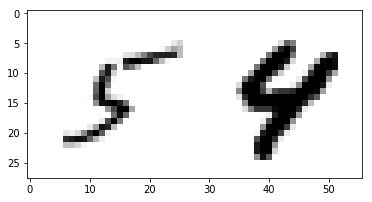

In [219]:
#see what an image from data looks like
digit_5 = data[35000].reshape(28, 28)
digit_4 = data[29999].reshape(28, 28)
digits = np.c_[digit_5, digit_4]
plt.imshow(digits, cmap = matplotlib.cm.binary, interpolation="nearest")

In [220]:
#train/test split (MNIST data set is already ready for split)
X_train, X_test, y_train, y_test = data[:60000], data[60000:], target[:60000], target[60000:]

#shuffle training set so that same numbers don't appear in a row
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#check train targets proportions
print ('train targets proportions')
get_proportions(y_train)

train targets proportions


1.0    0.112367
7.0    0.104417
3.0    0.102183
2.0    0.099300
9.0    0.099150
0.0    0.098717
6.0    0.098633
8.0    0.097517
4.0    0.097367
5.0    0.090350
Name: 0, dtype: float64

In [272]:
from sklearn.linear_model import SGDClassifier

#Binary classifier for the digit 5- if 5 true, if not 5 false
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

#stochastic gradient descent classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5.ravel())

#predict on our some_digit from before
print ('testing 5: ', sgd_clf.predict([digit_5.ravel()]))
print ('testing 4: ', sgd_clf.predict([digit_4.ravel()]))




testing 5:  [ True]
testing 4:  [False]


In [222]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

#k-fold cv implementation
def cross_validation(classifier, X, y, n_splits = 3):
    skfolds = StratifiedKFold(n_splits=n_splits, random_state=42)

    #need to reshape y to (y,) for cv
    y = y.reshape(y.shape[0],)
    
    print ('Cross validation results')
    
    for train_index, test_index in skfolds.split(X, y): 
        clone_clf = clone(classifier)
        X_train_folds = X[train_index]
        y_train_folds = (y[train_index])
        X_test_fold = X[test_index]
        y_test_fold = (y[test_index])

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)

        print(n_correct / len(y_pred)) 

#testing our 5-only classifier
cross_validation(sgd_clf, X_train, y_train_5)

Cross validation results
0.96175
0.9592
0.9394


In [223]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

#what accuracy will we get if we predict not-5 all the time?
#we're getting 90% (since only 10% of the examples are 5 - see proportions above).
#This means that accuracy measurement does not tell us much here
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

print ('Accuracy for predicting not-5 all the time')
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Accuracy for predicting not-5 all the time


array([ 0.90835,  0.9127 ,  0.9079 ])

In [230]:
from sklearn.model_selection import cross_val_predict

#Creating a confusion matrix for performance measuremence

#returns the predictions (instead of the performance scores)
y_train_5_reshaped = y_train_5.reshape(y_train_5.shape[0],)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5_reshaped, cv=3)
y_train_actuals = y_train_5

confusion_mat = confusion_matrix(y_train_actuals, y_train_pred)
print ('Confusion matrix')
print (confusion_mat)

tp = confusion_mat[1][1]
fp = confusion_mat[0][1]
tn = confusion_mat[0][0]
fn = confusion_mat[1][0]

print ('TP: {}, FP: {}, TN: {}, FN: {} \n'.format(tp, fp, tn, fn))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * ((precision * recall) / (precision + recall))
print ('precision: ', precision)
print ('recall: ', recall)
print ('f1: ', f1)


Confusion matrix
[[53978   601]
 [ 2192  3229]]
TP: 3229, FP: 601, TN: 53978, FN: 2192 

precision:  0.843080939948
recall:  0.595646559675
f1:  0.69808669333


confidence for a single positive example:  [ 82032.52626308]
confidence for a single negative example:  [-353938.12480219]
number of positives:  3830
number of positives:  56170
avreage positive confidence:  190162.559636
avreage negative confidence:  -549315.916135

Plot of precision-recall pairs for increasing threshold values
precision_score for threshold 70000:  0.91224419008


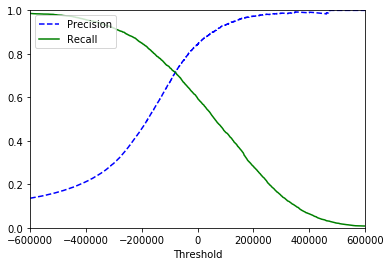

In [265]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#precision/recall tradeoff
#useful for when the positive examples are sparse

#by default the SGD classifier's threshold for positive example is above 0.
#get the confidence score of the classifier for true and false examples
print ('confidence for a single positive example: ', sgd_clf.decision_function([digit_5.ravel()]))
print ('confidence for a single negative example: ', sgd_clf.decision_function([digit_4.ravel()]))

#get confidence level for each example in training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5_reshaped, cv=3, method="decision_function")
y_positive = y_scores[y_scores > 0.0]
y_negative = y_scores[y_scores < 0.0]

print ('number of positives: ', len(y_positive))
print ('number of positives: ', len(y_negative))
print ('avreage positive confidence: ', np.mean(y_positive))
print ('avreage negative confidence: ', np.mean(y_negative))

#plot precision and recall for increasing thresholds
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x_range = [-600000, 600000]): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlim(x_range)
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

#get the precision and recall pairs for increasing threshold values
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print ('\nPlot of precision-recall pairs for increasing threshold values')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#example: setting a threshold that produces 90% precision
y_train_pred_90 = (y_scores > 70000)
print ('precision score for threshold 70000: ', precision_score(y_train_actuals, y_train_pred_90))


ROC Curve
Area under the curve:  0.943707071728


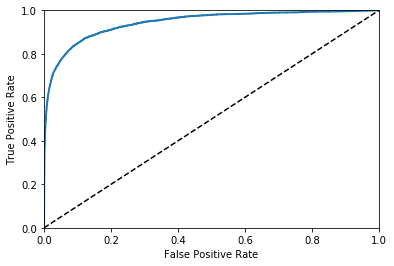

In [233]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#ROC Curve
#plots true positive rates (recall) against false positive rates for increasing threshold values

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
print ('ROC Curve')
plot_roc_curve(fpr, tpr)

print ('Area under the curve: ', roc_auc_score(y_train_5, y_scores))

In [249]:
from sklearn.ensemble import RandomForestClassifier

#Changing our model - random forest classifier

#get the probabilities for True and False classifications
#column 1 - prob of negative, column 2 - prob of positive
#default cutoff - 0.5
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5_reshaped)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5_reshaped, cv=3, method="predict_proba")


In [263]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_predictions = (y_probas_forest[:,1] >= 0.5)
precision_score(y_train_actuals, y_predictions)



0.96514907332796129

confidence (probability) for a single positive example:  [[ 0.  1.]]
confidence (probability) for a single negative example:  [[ 1.  0.]]
Number of positive predictions:  4964
Number of negative predictions:  4573
avreage positive confidence (probability):  0.5
avreage negative confidence (probability):  0.5

Plot of precision-recall pairs for increasing threshold values
precision score for 0.3 threshold : 0.8485245901639344 
recall score for 0.3 threshold : 0.9548053864600627


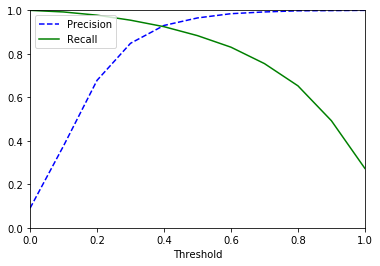

In [271]:
y_positive= y_probas_forest[y_probas_forest[:,1] >= 0.5]
y_negative = y_probas_forest[y_probas_forest[:,0] < 0.5]

print ('confidence (probability) for a single positive example: ', forest_clf.predict_proba([digit_5.ravel()]))
print ('confidence (probability) for a single negative example: ', forest_clf.predict_proba([digit_4.ravel()]))
print ('Number of positive predictions: ', len(y_positive))
print ('Number of negative predictions: ', len(y_negative))
print ('avreage positive confidence (probability): ', np.mean(y_positive))
print ('avreage negative confidence (probability): ', np.mean(y_negative))

#get the precision and recall pairs for increasing threshold values
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_probas_forest[:,1])

print ('\nPlot of precision-recall pairs for increasing threshold values')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x_range = [0, 1])

#Example: getting recall of ~95% and precision of ~84%
threshold = 0.30
y_recall_95 = (y_probas_forest[:,1] >= threshold)
print ('precision score for {} threshold : {} '.format(threshold, precision_score(y_train_actuals, y_recall_95)))
print ('recall score for {} threshold : {}'.format(threshold, recall_score(y_train_actuals, y_recall_95)))



Plot ROC Curve or SGD classifier against random forest
Area under the curve for the random forest classifers ROC curve:  0.992635371342


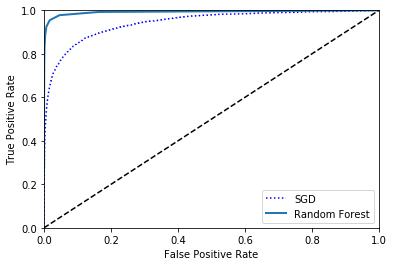

In [259]:
print ('\nPlot ROC Curve or SGD classifier against random forest')
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

print ('Area under the curve for the random forest classifers ROC curve: ', roc_auc_score(y_train_5, y_scores_forest))